<a href="https://colab.research.google.com/github/Taghr66d/MSc-SummerProject2025/blob/main/CuspNewPSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pycbc gwpy gwosc numpy scipy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [2]:

import numpy as np
from gwpy.timeseries import TimeSeries
from numpy.fft import rfft, rfftfreq, irfft
from scipy.signal import windows
from astropy import units as u
from tqdm import tqdm
import os

#  Config
sample_rate = 1024
delta_t = 1.0 / sample_rate
full_duration = 16.0
final_duration = 2.0   # saved window
sig_duration = 1.0
output_samples = int(sample_rate * final_duration)
low_freq_cutoff = 20.0
num_samples = 10

fftlen_whiten = 4.0 ###### # match PSD settings
safe_samples = int(sample_rate * (fftlen_whiten / 2.0))  # 2 s
margin = safe_samples + output_samples // 2               # keep crop away from whitening edges

rng = np.random.default_rng(12345)
script_index = 0
gps_start = 1126259456 + script_index * num_samples

#  Buffers
X = np.zeros((num_samples, output_samples), dtype=np.float32)
y = np.ones(num_samples, dtype=np.int32)  # 1 = cusp
snr_list, f_high_list, inject_indices, snr_obs_list = [], [], [], []

#  Helpers
def cusp_signal(amplitude=9.85e-22, f_high=340.0, dt=1/1024, duration=1.0, low_freq_cutoff=20.0):
    N = int(round(duration / dt))
    freqs = rfftfreq(N, d=dt)
    H = np.zeros_like(freqs, dtype=complex)
    mask = freqs >= low_freq_cutoff
    fpos = freqs[mask]
    spec = fpos ** (-4.0/3.0)
    tail = fpos >= f_high
    if np.any(tail):
        spec[tail] *= np.exp(1.0 - fpos[tail] / f_high)
    H[mask] = amplitude * spec
    H *= np.exp(-2j * np.pi * freqs * (duration / 2.0))  # center
    return irfft(H, n=N).real

def compute_standard_snr(signal, dt, psd_vals, psd_freqs, low_freq_cutoff=20.0):
    N = len(signal)
    df = 1.0 / (N * dt)
    freqs = rfftfreq(N, d=dt)
    S = rfft(signal) * dt
    band = freqs >= low_freq_cutoff
    if not np.any(band):
        return 0.0
    psd_interp = np.interp(freqs[band], psd_freqs, psd_vals, left=np.inf, right=np.inf)
    valid = np.isfinite(psd_interp) & (psd_interp > 0)
    if not np.any(valid):
        return 0.0
    snr2 = 4.0 * np.sum((np.abs(S[band][valid])**2) / psd_interp[valid]) * df
    return float(np.sqrt(max(snr2, 0.0)))

print("CUSP: PSD->scale->inject(unwhitened)->whiten(4s)->safe-crop 2s->zscore")
success = 0

for i in tqdm(range(num_samples * 3)):
    if success >= num_samples:
        break
    gps = gps_start + i
    try:
        # 1) 16 s real strain
        ts = TimeSeries.fetch_open_data('H1', gps, gps + full_duration)
        ts = ts.crop(ts.t0, ts.t0 + full_duration * u.s).resample(sample_rate)
        noise = ts.value.copy()

        # 2) PSD (4 s / 2 s) after highpass
        ts_psd = TimeSeries(noise, dt=delta_t).highpass(low_freq_cutoff)
        psd = ts_psd.psd(fftlength=fftlen_whiten, overlap=2.0)
        psd_freqs = psd.frequencies.value.astype(float)
        psd_vals = psd.value.astype(float)

        # 3) build cusp, taper, rescale to target SNR
        snr_target = float(rng.uniform(5.0, 20.0))
        f_high = float(rng.uniform(40.0, 340.0))
        cusp = cusp_signal(f_high=f_high, dt=delta_t, duration=sig_duration, low_freq_cutoff=low_freq_cutoff)
        cusp *= windows.tukey(len(cusp), alpha=0.2, sym=True)

        snr_meas = compute_standard_snr(cusp, delta_t, psd_vals, psd_freqs, low_freq_cutoff)
        if snr_meas <= 0 or not np.isfinite(snr_meas):
            continue
        cusp *= (snr_target / snr_meas)
        snr_obs = compute_standard_snr(cusp, delta_t, psd_vals, psd_freqs, low_freq_cutoff)

        # 4) inject into unwhitened noise, respecting margins
        max_inject_start = len(noise) - len(cusp)
        if max_inject_start <= 2 * margin:
            continue
        inject_start = rng.integers(margin, max_inject_start - margin + 1)
        noise[inject_start:inject_start + len(cusp)] += cusp

        # 5) whiten full 16 s with same PSD settings
        white = TimeSeries(noise, dt=delta_t).highpass(low_freq_cutoff).whiten(fftlength=fftlen_whiten, overlap=2.0).value

        # 6) pick a 2 s crop fully inside the safe region and covering the injection
        start_range = max(margin, inject_start - output_samples // 2)
        end_range = min(len(white) - margin - output_samples,
                        inject_start + len(cusp) - output_samples // 2)
        if end_range <= start_range:
            continue
        seg_start = rng.integers(start_range, end_range + 1)
        seg = white[seg_start:seg_start + output_samples].astype(np.float32, copy=True)
        inj_local = int(inject_start - seg_start)

        # 7) z-score
        std = float(np.std(seg))
        if std == 0.0 or not np.isfinite(std):
            continue
        seg = (seg - np.mean(seg)) / std

        # 8) store
        X[success] = seg
        y[success] = 1
        snr_list.append(snr_target)
        snr_obs_list.append(snr_obs)
        f_high_list.append(f_high)
        inject_indices.append(inj_local)
        success += 1

    except Exception as e:
        print("skip:", e)
        continue

#  Save (with extra key snr_check)
assert success == len(snr_list) == len(f_high_list) == len(inject_indices) == len(snr_obs_list)
X = X[:success]; y = y[:success]
outdir = "NewCuspDataset_REAL_PSD"; os.makedirs(outdir, exist_ok=True)
fname = os.path.join(outdir, f"2New_Cusp_RealNoise_{success}samples_test.npz")
np.savez_compressed(
    fname,
    X=X, y=y,
    snr=np.asarray(snr_list, dtype=np.float32),
    f_high=np.asarray(f_high_list, dtype=np.float32),
    inject_idx=np.asarray(inject_indices, dtype=np.int32),
    snr_check=np.asarray(snr_obs_list, dtype=np.float32),  # NEW (additive)
)
print(f"Dataset saved: {fname} | samples={success}")

/usr/local/lib/python3.11/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


CUSP: PSD->scale->inject(unwhitened)->whiten(4s)->safe-crop 2s->zscore


 33%|███▎      | 10/30 [00:16<00:32,  1.62s/it]

Dataset saved: NewCuspDataset_REAL_PSD/2New_Cusp_RealNoise_10samples_test.npz | samples=10


keys: ['X', 'y', 'snr', 'f_high', 'inject_idx', 'snr_check']


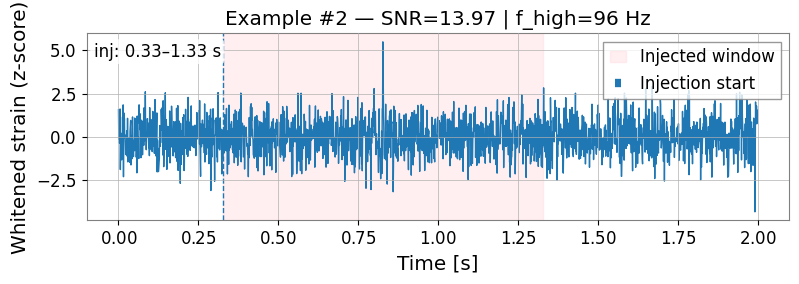

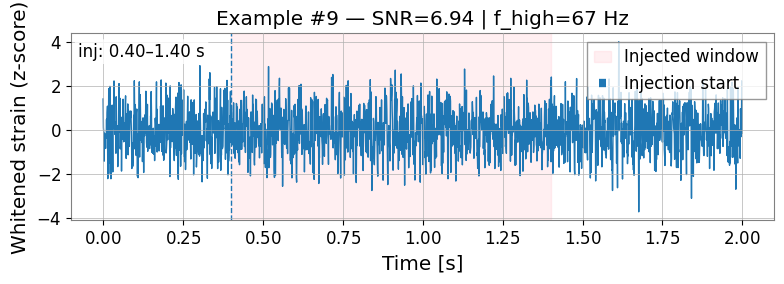

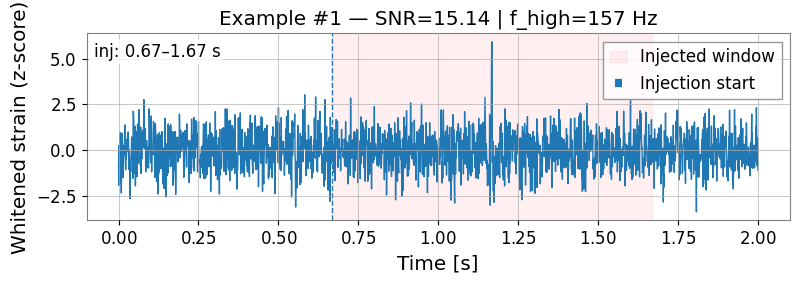

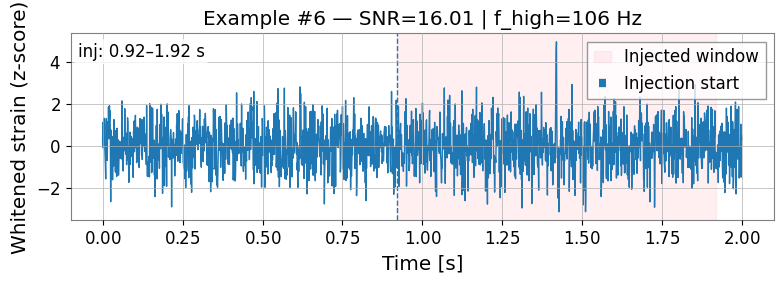

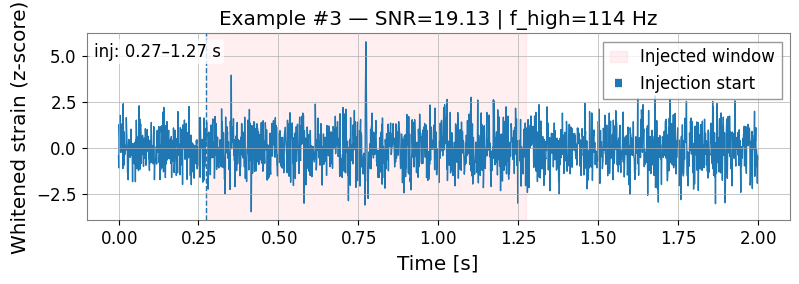

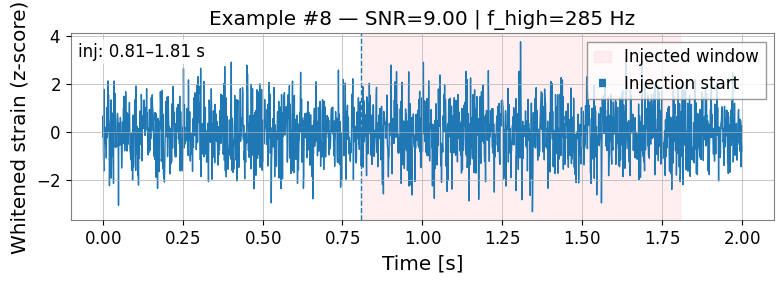

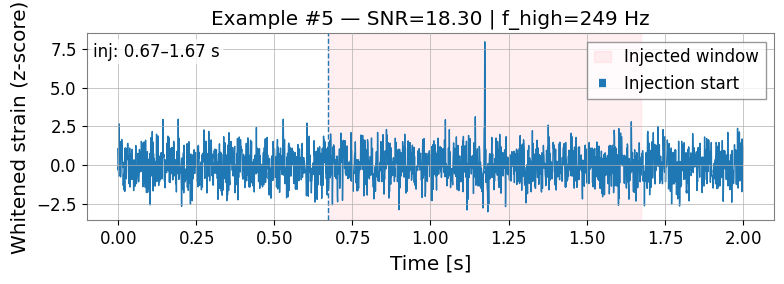

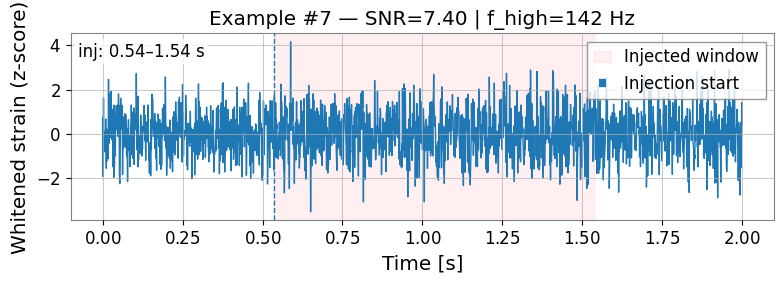

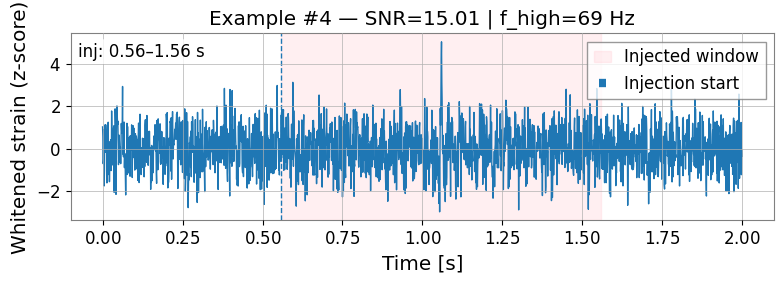

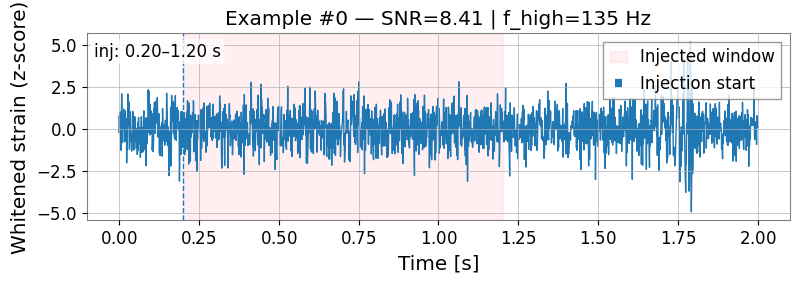

In [3]:
import numpy as np
import matplotlib.pyplot as plt

NPZ_PATH = "NewCuspDataset_REAL_PSD/2New_Cusp_RealNoise_10samples_test.npz"
data = np.load(NPZ_PATH)
print("keys:", data.files)

X = data["X"]
snr = data["snr"]
f_high = data["f_high"]
inject_idx = data["inject_idx"].astype(int)


def plot_examples_with_info(
    X, inject_idx, snr, f_high,
    sample_rate=1024, sig_duration=1.0,
    n_examples=10, rng_seed=42
):
    N, T = X.shape
    t = np.arange(T) / sample_rate
    rng = np.random.default_rng(rng_seed)
    idxs = rng.choice(N, size=min(n_examples, N), replace=False)

    for i in idxs:
        fig, ax = plt.subplots(figsize=(8, 3))
        ax.plot(t, X[i], linewidth=1)

        inj_start = float(inject_idx[i]) / sample_rate
        inj_end = inj_start + sig_duration

        # highlight the injected window
        ax.axvspan(max(0.0, inj_start), min(t[-1], inj_end), color="pink", alpha=0.25, label="Injected window")
        ax.axvline(inj_start, linestyle="--", linewidth=1, label="Injection start")

        ax.set_title(f"Example #{i} — SNR={snr[i]:.2f} | f_high={f_high[i]:.0f} Hz")
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Whitened strain (z-score)")
        ax.text(0.01, 0.95, f"inj: {inj_start:.2f}–{inj_end:.2f} s",
                transform=ax.transAxes, va="top", ha="left",
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8, linewidth=0))
        ax.legend(loc="upper right")
        fig.tight_layout()


plot_examples_with_info(
    X, inject_idx, snr, f_high,
    sample_rate=1024,
    sig_duration=1.0,
    n_examples=10
)
plt.show()

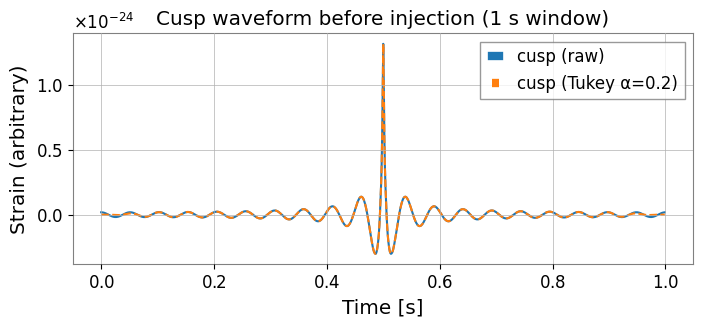

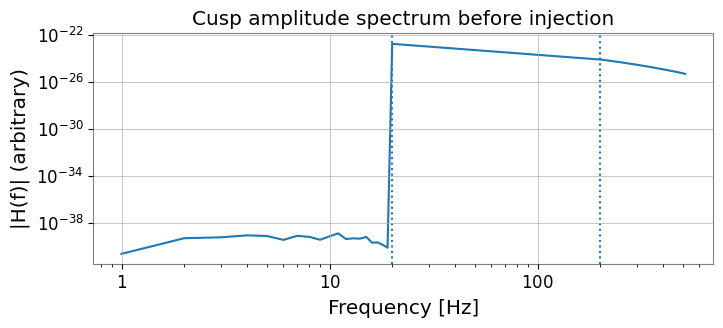

Duration = 1.0s, fs = 1024 Hz, samples = 1024
Peak time-domain amplitude (raw) = 1.314e-24


In [4]:
# Cusp before injection with Tukey W.
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq, irfft
from scipy.signal import windows

def cusp_signal(amplitude=9.85e-22, f_high=340.0, dt=1/1024, duration=1.0, low_freq_cutoff=20.0):
    N = int(round(duration / dt))
    freqs = rfftfreq(N, d=dt)
    H = np.zeros_like(freqs, dtype=complex)
    mask = freqs >= low_freq_cutoff
    fpos = freqs[mask]
    spec = fpos ** (-4.0/3.0)
    tail = fpos >= f_high
    if np.any(tail):
        spec[tail] *= np.exp(1.0 - fpos[tail] / f_high)
    H[mask] = amplitude * spec
    H *= np.exp(-2j * np.pi * freqs * (duration / 2.0))
    return irfft(H, n=N).real

fs = 1024
dt = 1.0 / fs
duration = 1.0
low = 20.0
f_high = 200.0

h = cusp_signal(f_high=f_high, dt=dt, duration=duration, low_freq_cutoff=low)
t = np.arange(len(h)) * dt
taper = windows.tukey(len(h), alpha=0.2, sym=True)
h_taper = h * taper

plt.figure(figsize=(8,3))
plt.plot(t, h, label="cusp (raw)")
plt.plot(t, h_taper, linestyle="--", label="cusp (Tukey α=0.2)")
plt.xlabel("Time [s]")
plt.ylabel("Strain (arbitrary)")
plt.title("Cusp waveform before injection (1 s window)")
plt.legend()
plt.show()

H = rfft(h)
f = rfftfreq(len(h), d=dt)
amp = np.abs(H)
plt.figure(figsize=(8,3))
plt.loglog(f[1:], amp[1:])
plt.axvline(low, linestyle=":")
plt.axvline(f_high, linestyle=":")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|H(f)| (arbitrary)")
plt.title("Cusp amplitude spectrum before injection")
plt.show()

print(f"Duration = {duration}s, fs = {fs} Hz, samples = {len(h)}")
print(f"Peak time-domain amplitude (raw) = {np.max(np.abs(h)):.3e}")